In [2]:
import pandas as pd
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
data_path = "../model/predictions/predictions_summary_rgcn_synthetic.csv"
df = pd.read_csv(data_path)

In [11]:
"""
Brownian Hitting Time (BHT) Model Functions
Converted from R/S-plus code
Original date: Sep 8 1998

WARNING: gamma is defined as coefficient of variation (c.o.v.)
"""

import numpy as np
from scipy.stats import norm, chi2
from scipy.optimize import brentq
import matplotlib.pyplot as plt


def pbht(x, mu=1.0, gamma=1.0):
    """
    Brownian hitting time distribution function (CDF)

    Parameters:
    -----------
    x : array-like
        Values at which to evaluate the CDF
    mu : float or array-like
        Mean parameter (must be positive)
    gamma : float or array-like
        Coefficient of variation (must be positive)

    Returns:
    --------
    p : array-like
        CDF values
    """
    x = np.asarray(x)
    mu = np.asarray(mu)
    gamma = np.asarray(gamma)

    if np.any(mu <= 0):
        raise ValueError("mu must be positive")
    if np.any(gamma <= 0):
        raise ValueError("gamma must be positive")

    a = np.sqrt(x / mu)
    b = x / mu

    # Use np.where instead of ifelse
    p = np.where(
        x > 0,
        norm.cdf((a - 1/a) / gamma) + np.exp(2 / gamma**2) * norm.cdf(-(a + 1/a) / gamma),
        0
    )

    return p


def dbht(x, mu=1.0, gamma=1.0):
    """
    Brownian hitting time density function (PDF)

    Parameters:
    -----------
    x : array-like
        Values at which to evaluate the PDF
    mu : float or array-like
        Mean parameter (must be positive)
    gamma : float or array-like
        Coefficient of variation (must be positive)

    Returns:
    --------
    d : array-like
        PDF values
    """
    x = np.asarray(x)
    mu = np.asarray(mu)
    gamma = np.asarray(gamma)

    if np.any(mu <= 0):
        raise ValueError("mu must be positive")
    if np.any(gamma <= 0):
        raise ValueError("gamma must be positive")

    d = np.where(
        x > 0,
        (np.sqrt(mu / (2 * np.pi * x**3)) / gamma) * np.exp(-(x - mu)**2 / (2 * mu * gamma**2 * x)),
        0
    )

    return d


def hbht(x, mu=1.0, gamma=1.0):
    """
    Brownian hitting time hazard function

    Parameters:
    -----------
    x : array-like
        Values at which to evaluate the hazard
    mu : float
        Mean parameter
    gamma : float
        Coefficient of variation

    Returns:
    --------
    h : array-like
        Hazard function values
    """
    return dbht(x, mu, gamma) / (1 - pbht(x, mu, gamma))

def residual_life_density(t, v, mu, gamma):
    return dbht(t + v, mu, gamma) / (1 - pbht(t))

def qbht1(p1, mu, gamma):
    """
    Helper function for qbht - single quantile calculation using bisection

    Parameters:
    -----------
    p1 : float
        Probability value (0 < p1 < 1)
    mu : float
        Mean parameter
    gamma : float
        Coefficient of variation

    Returns:
    --------
    xmd : float
        Quantile value
    """
    tol = 0.00001
    xhi = 1.0

    # Find upper bound
    while pbht(xhi, mu, gamma) < p1:
        xhi = 2 * xhi

    xlo = 0.0

    # Bisection search
    while xhi - xlo > tol:
        xmd = (xlo + xhi) / 2
        if pbht(xmd, mu, gamma) < p1:
            xlo = xmd
        else:
            xhi = xmd

    return xmd


def qbht(p, mu=1.0, gamma=1.0):
    """
    Brownian hitting time quantile function

    Parameters:
    -----------
    p : array-like
        Probability values (0 < p < 1)
    mu : float
        Mean parameter
    gamma : float
        Coefficient of variation

    Returns:
    --------
    q : array-like
        Quantile values
    """
    p = np.asarray(p)

    if np.isscalar(p):
        return qbht1(p, mu, gamma)
    else:
        return np.array([qbht1(p_i, mu, gamma) for p_i in p])


def rbht(n, mu, gamma):
    """
    Random variates from inverse Gaussian distribution

    Reference:
        Chhikara and Folks, The Inverse Gaussian Distribution,
        Marcel Dekker, 1989, page 53.

    Parameters:
    -----------
    n : int
        Number of random variates
    mu : float
        Mean parameter (must be positive)
    gamma : float
        Coefficient of variation (must be positive)

    Returns:
    --------
    r : array
        Random variates
    """
    if mu <= 0:
        raise ValueError("mu must be positive")
    if gamma <= 0:
        raise ValueError("gamma must be positive")

    y2 = chi2.rvs(1, size=n)
    u = np.random.uniform(0, 1, size=n)

    r1 = (mu * gamma**2 / 2) * (2 / gamma**2 + y2 - np.sqrt(4 * y2 / gamma**2 + y2**2))
    r2 = mu**2 / r1

    r = np.where(u < mu / (mu + r1), r1, r2)

    return r


def llbht(x, y=None, mu=1.0, gamma=1.0):
    """
    Evaluate BHT log-likelihood for point process data

    Parameters:
    -----------
    x : array-like
        Observed "closed intervals"
    y : array-like, optional
        Observed "open intervals"
    mu : float
        Mean parameter
    gamma : float
        Coefficient of variation

    Returns:
    --------
    ll : float
        Log-likelihood value
    """
    x = np.asarray(x)

    llc = np.sum(np.log(dbht(x, mu, gamma)))

    if y is None:
        llo = 0
    else:
        y = np.asarray(y)
        llo = np.sum(np.log(1 - pbht(y, mu, gamma)))

    return llc + llo


def rbhtpp(tt, mu, gamma):
    """
    Random Brownian hitting time point process

    Parameters:
    -----------
    tt : float
        Time horizon
    mu : float
        Mean parameter
    gamma : float
        Coefficient of variation

    Returns:
    --------
    result : dict
        Dictionary with keys 'x', 'y', 'tMax'
    """
    tMax = np.random.exponential(mu)
    n = max(1, int(np.ceil(2 * tt / mu)))
    z = rbht(n, mu, gamma)
    sz = np.cumsum(z)

    while np.max(sz) < tt:
        zNew = rbht(n, mu, gamma)
        z = np.concatenate([z, zNew])
        sz = np.concatenate([sz, np.max(sz) + np.cumsum(zNew)])

    # Find last index where sz <= tt
    ti = np.max(np.where(sz <= tt)[0])

    x = np.diff(np.concatenate([[0], sz[:ti+1]]))
    y = tt - sz[ti]

    return {'x': x, 'y': y, 'tMax': tt}


def mbht(tt, mu, gamma, plot=True):
    """
    Renewal function, M(t) = E(N(t)), for BHT point process

    Parameters:
    -----------
    tt : array-like
        Time points
    mu : float
        Mean parameter
    gamma : float
        Coefficient of variation
    plot : bool
        Whether to plot the results

    Returns:
    --------
    result : dict
        Dictionary with 'm', 'mdiff', 'coef', 'theta'
    """
    tt = np.asarray(tt)
    epsilon = 0.001
    done = False
    n = 1
    m = np.zeros_like(tt)

    while not done:
        Fn = pbht(tt, n * mu, gamma / np.sqrt(n))
        m = m + Fn
        a = np.max(Fn)
        if a < epsilon:
            done = True
        n = n + 1

    nt = len(tt)
    intcpt = m[nt-1] - tt[nt-1] / mu
    mdiff = m - intcpt - tt / mu

    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(tt, mdiff, 'b-')
        plt.axhline(y=0, linestyle='--', color='gray')
        plt.xlabel('Time')
        plt.ylabel('M(t) - intercept - t/mu')
        plt.title('Renewal Function Difference')
        plt.grid(True, alpha=0.3)
        plt.show()

    return {
        'm': m,
        'mdiff': mdiff,
        'coef': np.array([intcpt, 1/mu]),
        'theta': np.array([mu, gamma])
    }


def bm(tt, mu, sigma):
    """
    Generate Brownian motion process with drift = mu, scale = sigma
    at time points tt. Initial condition is X(0) = 0.

    Parameters:
    -----------
    tt : array-like
        Time points (must be non-negative)
    mu : float
        Drift parameter
    sigma : float
        Scale parameter

    Returns:
    --------
    x : array
        Brownian motion path
    """
    tt = np.asarray(tt)

    if np.any(tt < 0):
        raise ValueError("Time must be nonnegative")

    if tt[0] == 0:
        y1 = 0
    else:
        y1 = np.random.normal(mu * tt[0], sigma * np.sqrt(tt[0]))

    dt = np.diff(tt)
    y = np.random.normal(mu * dt, sigma * np.sqrt(dt))
    x = np.cumsum(np.concatenate([[y1], y]))

    return x


def hmean(data):
    """
    Compute the harmonic mean of data

    Parameters:
    -----------
    data : array-like
        Data values (must be positive)

    Returns:
    --------
    hm : float
        Harmonic mean
    """
    data = np.asarray(data)

    if np.any(data <= 0):
        raise ValueError("data must be positive")

    return 1 / np.mean(1 / data)


def mlebht(data):
    """
    Maximum likelihood estimation of inverse Gaussian parameters
    from grouped data assumed to have common coefficient of variation, gamma.

    Note: There's a comment in original code suggesting muhat and muhat1
    might be reversed.

    Parameters:
    -----------
    data : list of arrays
        List where each element is a sequence of interevent times

    Returns:
    --------
    result : dict
        Dictionary with 'muhat', 'muhat1', 'gammahat'
    """
    # Calculate sample means and harmonic means for each group
    tbar = np.array([np.mean(group) for group in data])
    ttilde = np.array([hmean(group) for group in data])
    alpha = tbar / ttilde - 1
    n = np.array([len(group) for group in data])
    N = np.sum(n)
    tol = 0.001 * np.sum(tbar * n) / N
    G = len(n)
    muhat = ttilde.copy()

    def a(i, mu, tbar, ttilde, n):
        a1 = np.sum(n * tbar / mu) - n[i] * tbar[i] / mu[i]
        a2 = np.sum(n * mu / ttilde) - n[i] * mu[i] / ttilde[i]
        return a1 + a2

    converged = False
    while not converged:
        for g in range(G):
            muhatOld = muhat.copy()
            c2 = (n[g] - N) / ttilde[g]
            c1 = a(g, muhat, tbar, ttilde, n) - 2 * N
            c0 = (n[g] + N) * tbar[g]
            disc = c1**2 - 4 * c2 * c0
            rts = (-c1 + np.array([-1, 1]) * np.sqrt(disc)) / (2 * c2)
            muhat[g] = np.max(rts)

        delta = np.sqrt(np.sum((muhat - muhatOld)**2))
        converged = delta < tol

    alphahat = (np.sum(n * tbar / muhat) + np.sum(n * muhat / ttilde)) / N - 2
    gammahat = np.sqrt(alphahat)

    return {
        'muhat': muhat,
        'muhat1': tbar,
        'gammahat': gammahat
    }


def fitbht(x):
    """
    Estimate parameters of BHT (IG) distribution using minimum variance
    unbiased estimation (MVUE).

    Parameters are:
        mu = mean
        rho = "regularity" = mu^2/sigma^2 = (c.o.v.)^-2

    For mu, the MVUE and MLE coincide: sample mean.
    For rho, the MVUE differs from MLE:
        rhoU = ((n-3) * rhoHat - 1) / n
    The MVUE requires that n > 3.

    Parameters:
    -----------
    x : array-like
        Data sequence

    Returns:
    --------
    result : array
        [muhat, rhoHat, rhoU]
    """
    x = np.asarray(x)
    n = len(x)
    xbar = np.mean(x)
    xh = hmean(x)
    rhoHat = xh / (xbar - xh)

    if n > 3:
        rhoU = ((n - 3) * rhoHat - 1) / n
    else:
        rhoU = np.nan

    return np.array([xbar, rhoHat, rhoU])


def cbht(x, dx, mu=1.0, gamma=1.0):
    """
    Conditional probability for BHT in interval from x to x + dx

    Parameters:
    -----------
    x : float or array-like
        Starting point
    dx : float
        Interval width
    mu : float
        Mean parameter
    gamma : float
        Coefficient of variation

    Returns:
    --------
    cp : float or array
        Conditional probability
    """
    return (pbht(x + dx, mu, gamma) - pbht(x, mu, gamma)) / (1 - pbht(x, mu, gamma))

In [12]:
df

,time_index,node_idx,true_label,predicted_label
0,0,0,99.0,99.132477
1,0,1,96.0,40.956608
2,0,2,82.0,79.577866
3,0,3,36.0,63.594151
4,0,4,89.0,48.243237
...,...,...,...,...
118995,594,195,-1.0,20.151955
118996,594,196,-1.0,20.154488
118997,594,197,-1.0,11.832365
118998,594,198,-1.0,22.571928


# BINARY CLASSIFICATION TASK

In [15]:
prediction_series = {}
label_series = {}

for row in df.iterrows():
  row = row[1]
  if (row["horizon_days"] == 30):
    preds_for_node = prediction_series.setdefault(row["node_idx"], [])
    labels_for_node = label_series.setdefault(row["node_idx"], [])
    preds_for_node.append(row["predicted_label"])
    labels_for_node.append(row["true_label"])


KeyError: 'horizon_days'

### Recurrence time histograms for true and model

In [13]:
def get_recurrence_times_binary_classification(series):
  recurrence_times = []
  curr_recurrence = 0

  for pred in series:
    if pred:
      recurrence_times.append(curr_recurrence)
      curr_recurrence = 0
    else:
      curr_recurrence += 1

  return recurrence_times

import matplotlib.pyplot as plt

plt.hist(get_recurrence_times_binary_classification(label_series[0]))
plt.xlabel("recurrence time")
plt.ylabel("count")
plt.title("true recurrence time distribution for single node")

NameError: name 'label_series' is not defined

In [14]:

plt.hist(get_recurrence_times_binary_classification(prediction_series[0]))
plt.xlabel("recurrence time")
plt.ylabel("count")
plt.title("model predictions recurrence time distribution for single node")

NameError: name 'prediction_series' is not defined

##True distribution pdf for node 0:

/tmp/ipython-input-3824356780.py:84: RuntimeWarning: divide by zero encountered in divide
  (np.sqrt(mu / (2 * np.pi * x**3)) / gamma) * np.exp(-(x - mu)**2 / (2 * mu * gamma**2 * x)),
/tmp/ipython-input-3824356780.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  (np.sqrt(mu / (2 * np.pi * x**3)) / gamma) * np.exp(-(x - mu)**2 / (2 * mu * gamma**2 * x)),
/tmp/ipython-input-3824356780.py:84: RuntimeWarning: invalid value encountered in scalar multiply
  (np.sqrt(mu / (2 * np.pi * x**3)) / gamma) * np.exp(-(x - mu)**2 / (2 * mu * gamma**2 * x)),


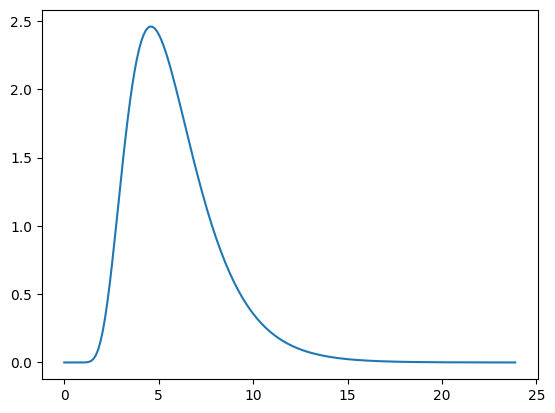

In [ ]:
import math

stress_drop = 4e6
R = 50 #change this so it's different for each node
c = 7.0 / 16.0
shear_modulus = 3e10
u = stress_drop * R / (c * shear_modulus * math.pi)
gamma = .4
lr = .01
mu_rec = u/lr

domain = np.arange(0, 2, .01)
plt.plot(domain * 12, [dbht(x, mu_rec, gamma) for x in domain])

# RECURRENCE TIME PREDICTION TASK

In [16]:
prediction_series = {}
label_series = {}

for row in df.iterrows():
    row = row[1]
    preds_for_node = prediction_series.setdefault(row["node_idx"], [])
    labels_for_node = label_series.setdefault(row["node_idx"], [])
    preds_for_node.append(row["predicted_label"])
    labels_for_node.append(row["true_label"])

In [17]:
def get_recurrence_times_recurrence_prediction(series, tolerance=0):
    recurrence_times = []
    index_of_recurrence = []
    last_pred = float("-inf")
    for i, pred in enumerate(series):
        if pred > last_pred + tolerance:
            index_of_recurrence.append(i)
            recurrence_times.append(pred)
        last_pred = pred
    return recurrence_times, index_of_recurrence

Text(0.5, 1.0, 'predicted recurrence time distribtion for node 80')

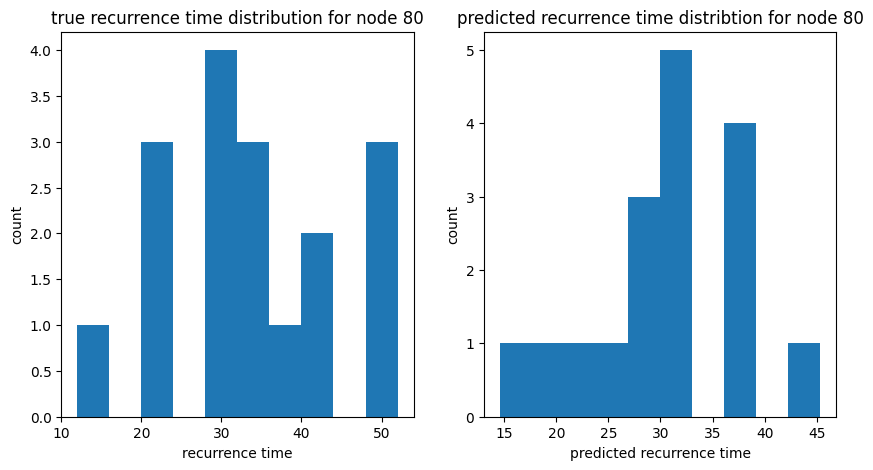

In [33]:
node_id = 80
recurrence_times, index_of_recurrence = get_recurrence_times_recurrence_prediction(label_series[node_id])
predicted_rec_times = np.asarray(prediction_series[node_id])[np.array(index_of_recurrence) + 1]
fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig1.set_size_inches(10, 5)
ax1.hist(recurrence_times)
ax1.set_xlabel("recurrence time")
ax1.set_ylabel("count")
ax1.set_title("true recurrence time distribution for node {}".format(node_id))

ax2.hist(predicted_rec_times)
ax2.set_xlabel("predicted recurrence time")
ax2.set_ylabel("count")
ax2.set_title("predicted recurrence time distribtion for node {}".format(node_id))

In [28]:
prediction_series[node_id][0]

np.float64(99.13247680664062)

In [29]:
label_series[node_id][0]

np.float64(99.0)